In [109]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from financepy.models.black_scholes_analytic import bs_value, bs_delta
from financepy.utils.global_types import OptionTypes
from financepy.utils import *
from financepy.products.rates import *
from financepy.products.credit import *
from financepy.market.curves import *

from scipy.stats import lognorm, norm

np.random.seed(42)

# **1. This question is about Black-Scholes-Merton Hedging.**

### (a) Install FinancePy and for speed issues, in the following, call directly into the model library rather than go via the EquityOptions class.

### (b) Write a Python function called DeltaHedge that simulates the delta hedging of a European put option from trade date until expiry using a self-financing portfolio.

$$
d\ln S_t = \left[ ( r - q ) - \tfrac{1}{2}\sigma^2 \right] dt + \sigma \sqrt{dt}\, Z_t
$$


In [110]:
def MC_simulation_BS(S_0: float,
                     T: float,
                     r: float,
                     q: float,
                     sigma: float,
                     steps: int,
                     num_paths: int,
                     mu: float = None 
                     ) -> np.array:

    dt = T / steps
    sqrt_dt = np.sqrt(dt)
    Z = np.random.standard_normal( (num_paths, steps) )
    
    # Use real-world drift mu if provided, otherwise default to risk-neutral drift
    drift = ( mu if mu is not None else (r - q) )
    
    dlogS = ( drift - 0.5 * sigma**2 ) * dt + ( sigma * sqrt_dt * Z )
    logS = np.log(S_0) + np.cumsum(dlogS, axis=1)
    
    S0 = np.full(shape=(num_paths, 1), fill_value=S_0)
    S = np.hstack([S0, np.exp(logS)])
    
    return S

### (c) Write another function that calls the previous DeltaHedge function and which can then be used to calculate the hedging error over 10,000 different paths.

In [111]:
def DeltaHedge(S_0: float, 
               K: float, 
               T: float, 
               r: float, 
               q: float, 
               mu: float, 
               sigma: float, 
               N: int, 
               num_paths: int,
               opt_type: int):
    """
    Simulates the delta hedging of a European put option.

    Args:
        S0 (float): Initial stock price.
        K (float): Option strike price.
        T (float): Time to expiry in years.
        r (float): Risk-free interest rate.
        q (float): Dividend yield.
        mu (float): Real-world drift of the stock.
        sigma (float): Realized volatility of the stock path.
        N (int): Number of hedging steps per year.
        num_paths (int): Number of Monte Carlo simulation paths.

    Returns:
        tuple: (Terminal Stock Price, Option Payoff, Realized Variance, Replicating Error)
    """
    
    dt = T / N
    steps = int(N * T)

    # 1. SIMULATE STOCK PATHS in the real world (using mu and sigma_real)
    St = MC_simulation_BS(S_0, T, r, q, sigma, steps, num_paths, mu=mu)
    
    # 2. SET UP PORTFOLIO at time t=0
    time_grid = np.linspace(0, T, steps + 1)
    time_to_maturity = T - time_grid

    # Initial option price (premium received by the seller)
    initial_option_price = bs_value(S_0, T, K, r, q, sigma, opt_type)
    
    # Initial delta and portfolio composition
    delta_t = bs_delta(St[:, 0], time_to_maturity[0], K, r, q, sigma, opt_type)
    
    # We hold 'delta_t' shares and the rest is cash.
    # The cash position is the option premium cost plus the shares holded
    cash_account = initial_option_price - ( delta_t * St[:, 0] )
    interest_payment = np.zeros(shape=(num_paths, steps+ 1))
    
    # 3. DYNAMICALLY HEDGE OVER TIME
    for i in range(1, steps + 1):
        # Accrue interest on the cash account from the previous step
        interest_payment[:, i] = ( cash_account * np.exp(r * dt) ) - cash_account
        cash_account = cash_account * np.exp(r * dt)
        
        # Calculate the new delta based on the new stock price and time
        delta_t_new = bs_delta(St[:, i], time_to_maturity[i], K, r, q, sigma, opt_type)
        
        # Rebalance the portfolio: buy/sell shares to match the new delta.
        # The cost/proceeds of this trade are settled from/to the cash account.
        shares_to_trade = delta_t_new - delta_t
        cash_account -= shares_to_trade * St[:, i] # This is the self-financing step
        
        # Update delta for the next iteration
        delta_t = delta_t_new
        
    # 4. CALCULATE FINAL RESULTS AT EXPIRY (T)
    
    # The final value of the hedging portfolio
    final_portfolio_value = (delta_t * St[:, -1]) + cash_account 

    # The option payoff (what we owe the option holder)
    option_payoff = np.maximum(K - St[:, -1], 0.0)
    
    # The difference is our profit or loss
    replicating_error = final_portfolio_value - option_payoff
    
    # Calculate realized variance of log returns over the period
    log_returns = np.log(St[:, 1:] / St[:, :-1])
    realized_variance = np.var(log_returns, axis=1) * N # Annualize the variance
    
    terminal_stock_price = St[:, -1]

    return terminal_stock_price, option_payoff, realized_variance, replicating_error, final_portfolio_value

### (d) Consider a put option with S(0) = 100, K = 100, r = 4%, T = 1.0 and σ = 20%. Assume here that µ = 5%. For this option, make a scatterplot of the hedging error (y axis) versus the terminal stock price (x-axis) for N = 12 (monthly), N = 52 (weekly) and N =252 (daily). Use different symbols or colours to distinguish the points.

In [112]:
S0 = 100.0
K = 100.0
T = 1.0
r = 0.04
q = 0.0
mu = 0.1
sigma = 0.2
N = 252
num_paths = 10_000
opt_type = OptionTypes.EUROPEAN_PUT.value

Running simulation for N = 12...
Running simulation for N = 52...
Running simulation for N = 252...


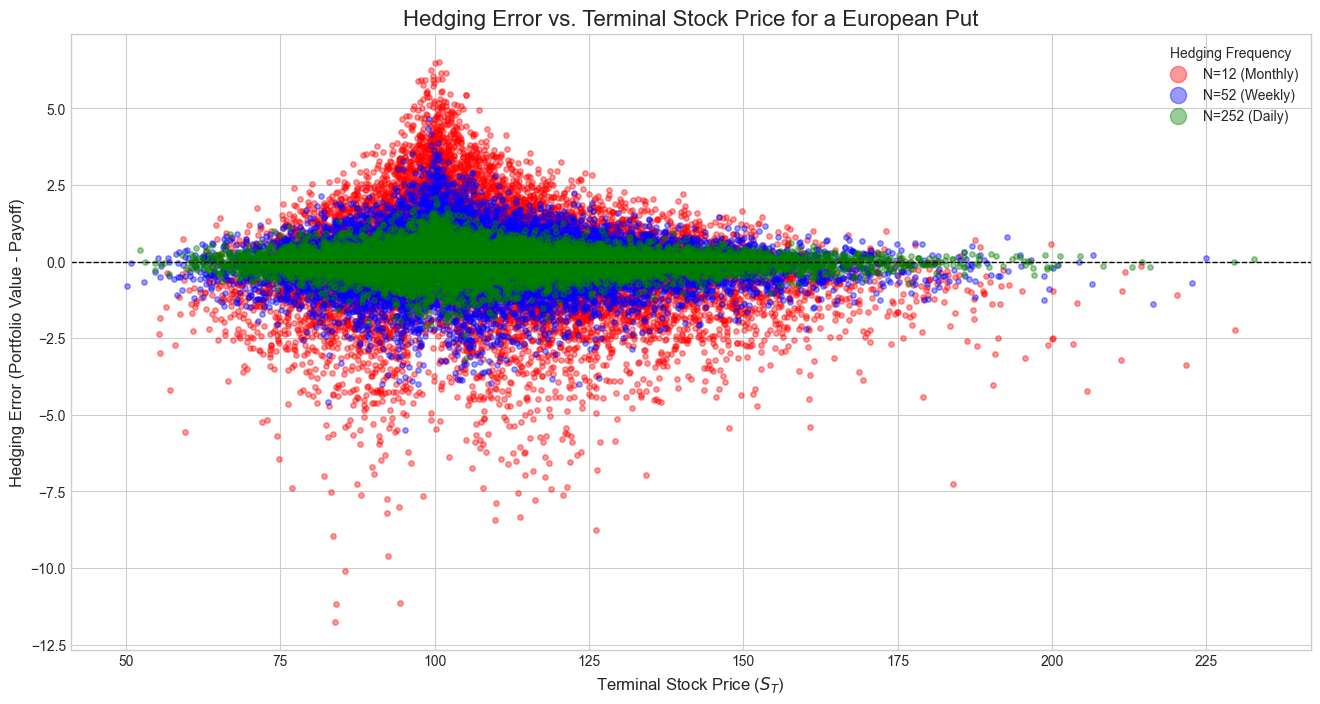

In [113]:
# Hedging frequencies to test
N_values = [12, 52, 252]
results = {}

# Run simulation for each frequency
for n in N_values:
    print(f"Running simulation for N = {n}...")
    S_T, payoff, real_var, error, final_portfolio_value = DeltaHedge(S0, K, T, r, q, mu, sigma, n, num_paths, opt_type)
    results[n] = {'S_T': S_T, 'error': error, 'final_portfolio_value': final_portfolio_value, 'payoff': payoff}

# Create the scatterplot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))

colors = {12: 'red', 52: 'blue', 252: 'green'}
labels = {12: 'N=12 (Monthly)', 52: 'N=52 (Weekly)', 252: 'N=252 (Daily)'}

for n in N_values:
    ax.scatter(results[n]['S_T'], results[n]['error'], 
               alpha=0.4, s=15, 
               c=colors[n], 
               label=labels[n])

ax.set_title('Hedging Error vs. Terminal Stock Price for a European Put', fontsize=16)
ax.set_xlabel('Terminal Stock Price ($S_T$)', fontsize=12)
ax.set_ylabel('Hedging Error (Portfolio Value - Payoff)', fontsize=12)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.legend(title='Hedging Frequency', markerscale=3)
plt.show()


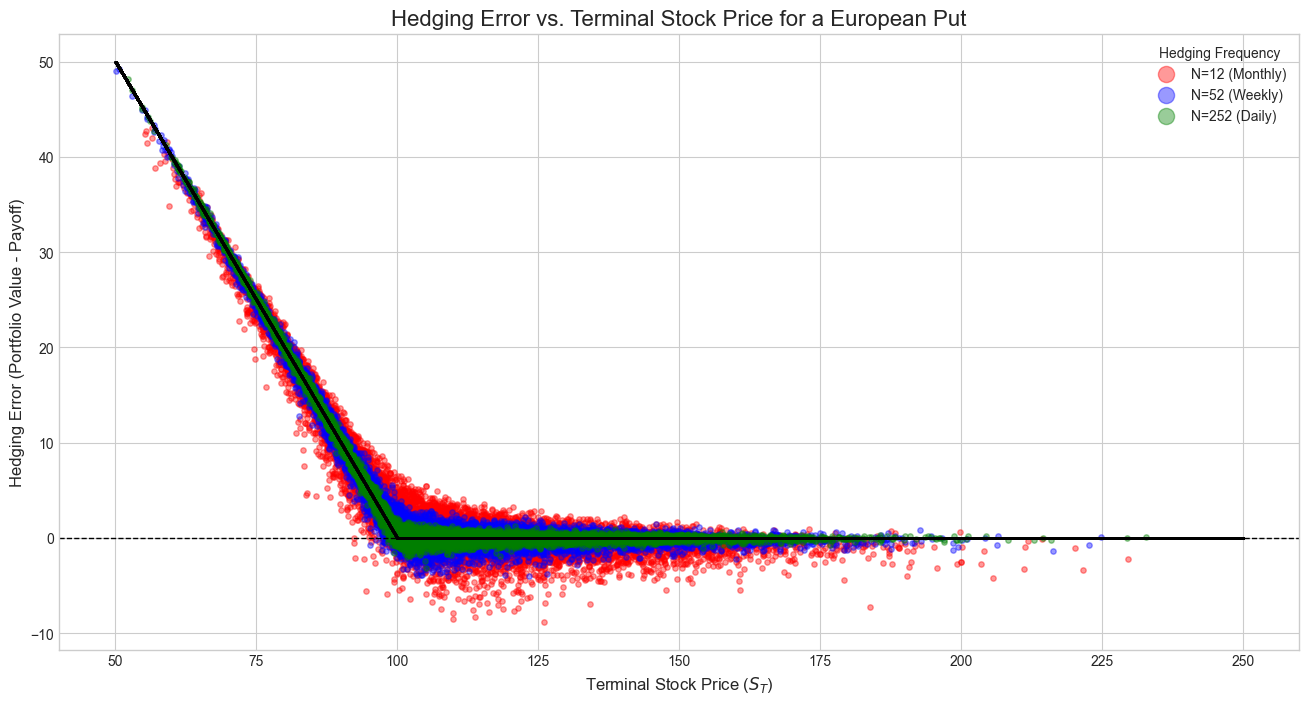

In [114]:
# Create the scatterplot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))

colors = {12: 'red', 52: 'blue', 252: 'green'}
labels = {12: 'N=12 (Monthly)', 52: 'N=52 (Weekly)', 252: 'N=252 (Daily)'}

payoff_plot = np.linspace(50, 250, 10000)
payoff__K_plot = np.maximum(K - payoff_plot, 0)

for n in N_values:
    ax.scatter(results[n]['S_T'], results[n]['final_portfolio_value'], 
               alpha=0.4, s=15, 
               c=colors[n], 
               label=labels[n])
    ax.scatter(payoff_plot, payoff__K_plot,
               color='black',
               s=1
               )

ax.set_title('Hedging Error vs. Terminal Stock Price for a European Put', fontsize=16)
ax.set_xlabel('Terminal Stock Price ($S_T$)', fontsize=12)
ax.set_ylabel('Hedging Error (Portfolio Value - Payoff)', fontsize=12)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.legend(title='Hedging Frequency', markerscale=3)
plt.show()

### (e) For each value of N also calculate the mean and variance of this option hedging error over 10,000 different paths. You can use this to generate the answers to the remaining parts of this question. Present this in a simple table format.

In [115]:
# Calculate the mean and variance for each hedging frequency
table_data = []
for n in N_values:
    # Access the array of hedging errors for the given frequency
    errors = results[n]['error']
    
    # Calculate mean and variance using NumPy
    mean_error = np.mean(errors)
    variance_error = np.var(errors)
    
    # Append the results for tabulation
    table_data.append([f'{labels[n]}', mean_error, variance_error])

# Create a pandas DataFrame to display the results in a simple table format
results_df = pd.DataFrame(table_data, 
                          columns=['Hedging Frequency', 
                                   'Mean Hedging Error', 
                                   'Variance of Hedging Error'])

# Display the final table
print(results_df.to_string(index=False))

Hedging Frequency  Mean Hedging Error  Variance of Hedging Error
   N=12 (Monthly)           -0.016438                   3.506675
    N=52 (Weekly)           -0.019651                   0.858727
    N=252 (Daily)           -0.004847                   0.183730


### (f) Create a scatterplot of the realized volatilities vs the replication error. Explain the pattern.

Running simulation for N = 12...
Running simulation for N = 52...
Running simulation for N = 252...


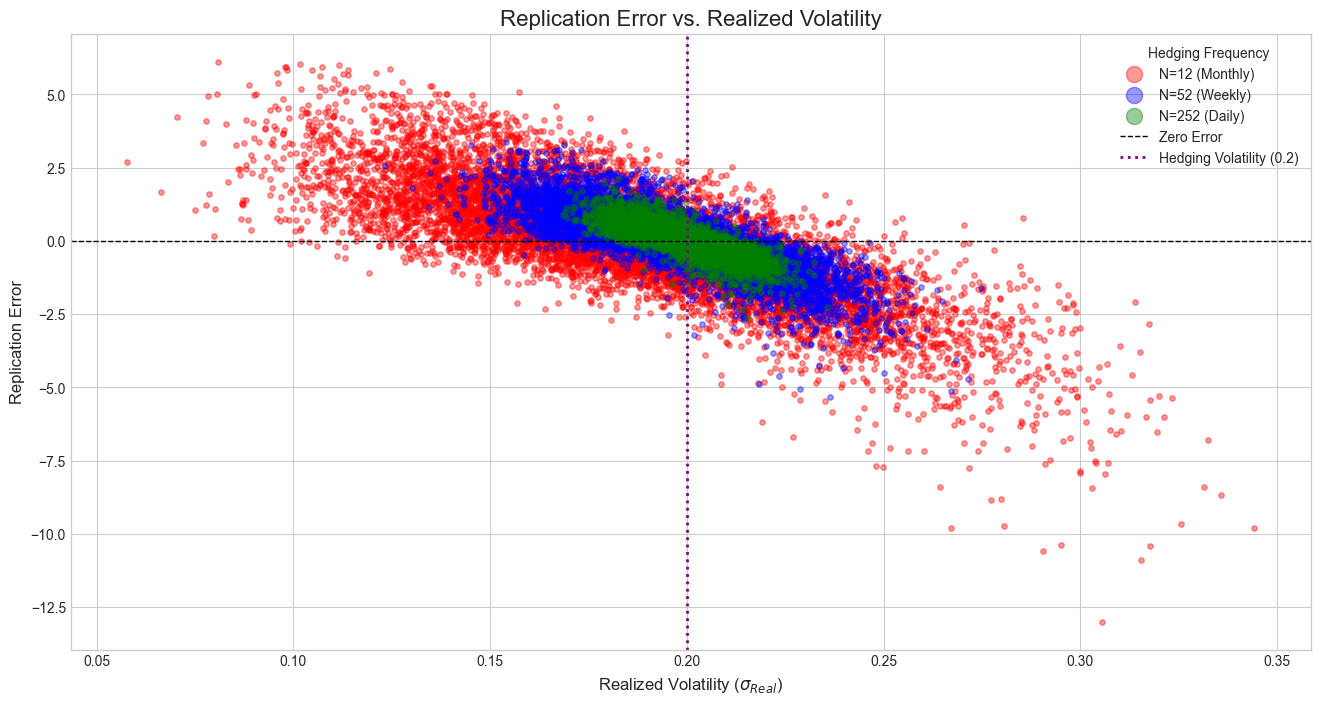

In [116]:
results_full = {}
for n in N_values:
    print(f"Running simulation for N = {n}...")
    S_T, payoff, real_var, error, _ = DeltaHedge(S0, K, T, r, q, mu, sigma, n, num_paths, opt_type)
    
    # We need the square root of variance to get volatility
    realized_vol = np.sqrt(real_var)
    
    results_full[n] = {'realized_vol': realized_vol, 'error': error}

# Create the scatterplot
fig, ax = plt.subplots(figsize=(16, 8))

for n in N_values:
    ax.scatter(results_full[n]['realized_vol'], results_full[n]['error'], 
               alpha=0.4, s=15, 
               c=colors[n], 
               label=labels[n])

ax.set_title('Replication Error vs. Realized Volatility', fontsize=16)
ax.set_xlabel('Realized Volatility ($\sigma_{Real}$)', fontsize=12)
ax.set_ylabel('Replication Error', fontsize=12)
ax.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Error')
ax.axvline(sigma, color='purple', linestyle=':', linewidth=2, label=f'Hedging Volatility ({sigma})')
ax.legend(title='Hedging Frequency', markerscale=3)
plt.show()

### (g) For the same put option, calculate the mean absolute error value and the variance of the hedging error for µ = 2.5%,5.0%,7.5%,10% by sampling 10,000 hedging paths using N = 52. Show the results in a table. What does this tell you? Does the value of the drift change the hedging by a little or a lot?

In [117]:
# Parameters for this question
N = 52 # Weekly hedging
mu_values = [0.025, 0.050, 0.075, 0.10]
results_drift = []

print("Running simulations for different drift values...")
for mu_val in mu_values:
    # Run the hedging simulation with the current drift value
    _, _, _, errors, _ = DeltaHedge(S0, K, T, r, q, mu_val, sigma, N, num_paths, opt_type)
    
    # Calculate the required metrics
    mean_abs_error = np.mean(errors)
    variance_error = np.var(errors)
    
    # Store the results
    results_drift.append([f'{mu_val:.1%}', mean_abs_error, variance_error])
    print(f"  μ = {mu_val:.1%}: Mean Error = {mean_abs_error:.4f}, Variance = {variance_error:.4f}")

# Create a pandas DataFrame to display the results in a table format
drift_df = pd.DataFrame(results_drift,
                        columns=['Real-World Drift (μ)', 
                                 'Mean Error', 
                                 'Variance of Hedging Error'])

print("\n--- Final Results Table ---")
print(drift_df.to_string(index=False))

Running simulations for different drift values...
  μ = 2.5%: Mean Error = -0.0007, Variance = 0.9352
  μ = 5.0%: Mean Error = -0.0063, Variance = 0.9016
  μ = 7.5%: Mean Error = -0.0047, Variance = 0.9232
  μ = 10.0%: Mean Error = 0.0002, Variance = 0.8520

--- Final Results Table ---
Real-World Drift (μ)  Mean Error  Variance of Hedging Error
                2.5%   -0.000651                   0.935183
                5.0%   -0.006317                   0.901595
                7.5%   -0.004689                   0.923220
               10.0%    0.000239                   0.852018


# **2. This question is about time-varying volatility.**

### (a) We start with the code of Question 1. However, we make one adjustment. Instead of having a constant volatility of 20%, we now have a volatility period of 4% for the first half of T and 28% for the second half. First, value a put option with S(0) = 100, K =100, r =4%, T =1.0 (same as in Q1). Compare this to the value of a put option with S(0) = 100, K = 100, r = 4%, T = 1.0 and σ = 20%. [Hint: There should be no difference]

In [118]:
# Parameters from the assignment
S0 = 100.0
K = 100.0
r = 0.04
T = 1.0
q = 0.0
opt_type = OptionTypes.EUROPEAN_PUT.value

# 1. Price the put option with CONSTANT volatility
sigma_const = 0.20
put_price_const = bs_value(S0, T, K, r, q, sigma_const, opt_type)

print(f"--- Constant Volatility (CV) Case ---")
print(f"Volatility = {sigma_const:.2%}")
print(f"Put Option Price (CV) = {put_price_const:.4f}")
print("-" * 40)

# 2. Price the put option with TIME-VARYING volatility
sigma1 = 0.04
sigma2 = 0.28
t1 = 0.5  # First half of the year

# Calculate the average variance over the full year T=1.0
avg_variance = (sigma1**2 * t1) + (sigma2**2 * (T - t1))
# Note: We divide by T, but since T=1.0, the value is the same.

# Calculate the effective (average) volatility
effective_sigma = np.sqrt(avg_variance)

put_price_tv = bs_value(S0, T, K, r, q, effective_sigma, opt_type)

print(f"--- Time-Varying Volatility (TV) Case ---")
print(f"Volatility σ₁ (First Half) = {sigma1:.2%}")
print(f"Volatility σ₂ (Second Half) = {sigma2:.2%}")
print(f"Average Variance = {avg_variance:.4f}")
print(f"Effective Volatility σ̄ = {effective_sigma:.2%}")
print(f"Put Option Price (TV) = {put_price_tv:.4f}")
print("-" * 40)

# 3. Compare the results
print(f"\nComparison:")
print(f"Price (CV) - Price (TV) = {put_price_const - put_price_tv:.6f}")

--- Constant Volatility (CV) Case ---
Volatility = 20.00%
Put Option Price (CV) = 6.0040
----------------------------------------
--- Time-Varying Volatility (TV) Case ---
Volatility σ₁ (First Half) = 4.00%
Volatility σ₂ (Second Half) = 28.00%
Average Variance = 0.0400
Effective Volatility σ̄ = 20.00%
Put Option Price (TV) = 6.0040
----------------------------------------

Comparison:
Price (CV) - Price (TV) = 0.000000


 ### (b) Now create an updated delta hedging function DeltaHedgeTV allowing for time varying volatility. [Hint: What happens to the average volatility when the time to maturity decreases?]

In [119]:
def MC_simulation_BS_TV(S_0: float, T: float, r: float, q: float, 
                        sigma1: float, sigma2: float, t_switch: float,
                        steps: int, num_paths: int, mu: float = None) -> np.array:
    """
    Monte Carlo simulation for Geometric Brownian Motion with piecewise constant volatility.
    """
    dt = T / steps
    sqrt_dt = np.sqrt(dt)
    
    # Create an array of volatilities for each time step
    time_grid = np.linspace(0, T, steps + 1)
    sigma_path = np.where(time_grid[1:] <= t_switch, sigma1, sigma2)
    
    Z = np.random.standard_normal((num_paths, steps))
    
    drift = (mu if mu is not None else (r - q))
    dlogS = (drift - 0.5 * sigma_path**2) * dt + sigma_path * sqrt_dt * Z
    
    logS = np.log(S_0) + np.cumsum(dlogS, axis=1)
    S0_array = np.full(shape=(num_paths, 1), fill_value=S_0)
    S = np.hstack([S0_array, np.exp(logS)])
    return S


def DeltaHedgeTV(S_0: float, K: float, T: float, r: float, q: float, mu: float, 
                 sigma_real1: float, sigma_real2: float,
                 sigma_hedge1: float, sigma_hedge2: float, t_switch: float,
                 N: int, num_paths: int, opt_type_value: int):
    """
    Simulates delta hedging of a European option with time-varying volatility.
    """

    dt = T / N
    steps = int(N * T)

    # --- 1. Simulate stock paths with time-varying REAL volatility ---
    St = MC_simulation_BS_TV(S_0, T, r, q,
                             sigma_real1, sigma_real2, t_switch,
                             steps, num_paths, mu=mu)

    # --- 2. Initial setup ---
    time_grid = np.linspace(0, T, steps + 1)

    # Effective volatility at t=0 (average over total horizon)
    initial_avg_var = (sigma_hedge1**2 * t_switch) + (sigma_hedge2**2 * (T - t_switch))
    sigma_eff = np.sqrt(initial_avg_var / T)

    # Initial option value and delta
    initial_option_price = bs_value(S_0, T, K, r, q, sigma_eff, opt_type_value)
    delta_t = bs_delta(St[:, 0], T, K, r, q, sigma_eff, opt_type_value)

    # Initial cash account (short put position)
    cash_account = initial_option_price - (delta_t * St[:, 0])

    # --- 3. Dynamic hedging ---
    for i in range(1, steps + 1):
        t_i = time_grid[i]
        tau = T - t_i  # time to maturity

        # compute effective vol for remaining time
        if tau == 0:
            sigma_eff = sigma_hedge2
        elif t_i < t_switch:
            remaining_var = (sigma_hedge1**2 * (t_switch - t_i)) + (sigma_hedge2**2 * (T - t_switch))
            sigma_eff = np.sqrt(remaining_var / tau)
        else:
            sigma_eff = sigma_hedge2

        # new delta
        delta_t_new = bs_delta(St[:, i], tau, K, r, q, sigma_eff, opt_type_value)

        # accrue interest & rebalance
        cash_account *= np.exp(r * dt)
        shares_to_trade = delta_t_new - delta_t
        cash_account -= shares_to_trade * St[:, i]
        delta_t = delta_t_new

    # --- 4. Final results ---
    final_portfolio_value = delta_t * St[:, -1] + cash_account
    option_payoff = np.maximum(K - St[:, -1], 0.0)
    replicating_error = final_portfolio_value - option_payoff

    log_returns = np.log(St[:, 1:] / St[:, :-1])
    realized_variance = np.var(log_returns, axis=1) * N
    terminal_stock_price = St[:, -1]

    return terminal_stock_price, option_payoff, realized_variance, replicating_error

### (c) Perform the delta hedge exercise from 1(d) again. How does the performance of the hedge compare with the constant volatility case?

Running Time-Varying Volatility Simulations...
  Running for N = 12...
  Running for N = 52...
  Running for N = 252...


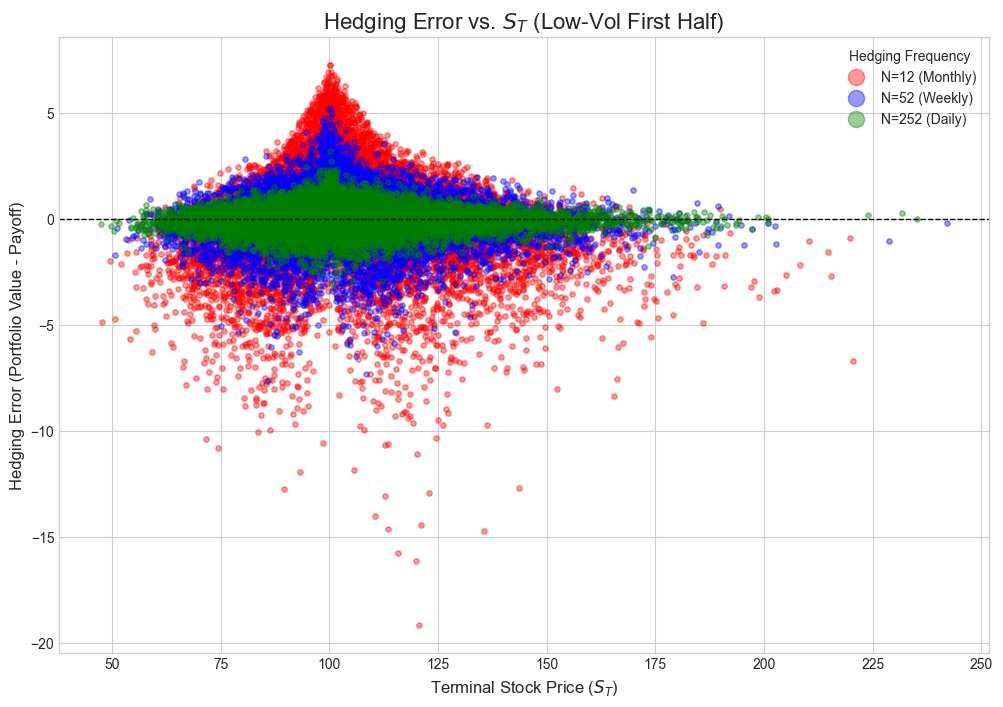


--- Hedging Performance (Time-Varying Volatility) ---
Hedging Frequency  Mean Hedging Error  Variance of Hedging Error
   N=12 (Monthly)           -0.027366                   6.821015
    N=52 (Weekly)            0.010765                   1.738329
    N=252 (Daily)           -0.003216                   0.365270

--- Hedging Performance (Constant Volatility) ---
Hedging Frequency  Mean Hedging Error  Variance of Hedging Error
   N=12 (Monthly)           -0.016438                   3.506675
    N=52 (Weekly)           -0.019651                   0.858727
    N=252 (Daily)           -0.004847                   0.183730


In [120]:
# Parameters for the Time-Varying (TV) scenario
sigma_real1 = 0.04
sigma_real2 = 0.28
sigma_hedge1 = 0.04
sigma_hedge2 = 0.28
t_switch = 0.5
mu = 0.05 # As per 1(d)

# Re-using N_values and labels from Q1
N_values = [12, 52, 252]
labels = {12: 'N=12 (Monthly)', 52: 'N=52 (Weekly)', 252: 'N=252 (Daily)'}
colors = {12: 'red', 52: 'blue', 252: 'green'}

results_tv = {}

# Run simulation for each frequency using the TV function
print("Running Time-Varying Volatility Simulations...")
for n in N_values:
    print(f"  Running for N = {n}...")
    S_T, _, _, error = DeltaHedgeTV(S0, K, T, r, q, mu, 
                                    sigma_real1, sigma_real2, 
                                    sigma_hedge1, sigma_hedge2, t_switch,
                                    N=n, num_paths=num_paths, opt_type_value=opt_type)
    results_tv[n] = {'S_T': S_T, 'error': error}

# --- Create the Scatterplot ---
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(results_tv[12]['S_T'], results_tv[12]['error'], alpha=0.4, s=15, c=colors[12], label=labels[12])
ax.scatter(results_tv[52]['S_T'], results_tv[52]['error'], alpha=0.4, s=15, c=colors[52], label=labels[52])
ax.scatter(results_tv[252]['S_T'], results_tv[252]['error'], alpha=0.4, s=15, c=colors[252], label=labels[252])

ax.set_title('Hedging Error vs. $S_T$ (Low-Vol First Half)', fontsize=16)
ax.set_xlabel('Terminal Stock Price ($S_T$)', fontsize=12)
ax.set_ylabel('Hedging Error (Portfolio Value - Payoff)', fontsize=12)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.legend(title='Hedging Frequency', markerscale=3)
plt.show()

# --- Quantitative Comparison Table ---
table_data_tv = []
for n in N_values:
    errors = results_tv[n]['error']
    mean_error = np.mean(errors)
    variance_error = np.var(errors)
    table_data_tv.append([labels[n], mean_error, variance_error])

results_df_tv = pd.DataFrame(table_data_tv, columns=['Hedging Frequency', 'Mean Hedging Error', 'Variance of Hedging Error'])

print("\n--- Hedging Performance (Time-Varying Volatility) ---")
print(results_df_tv.to_string(index=False))

# For comparison, here is the table from the constant volatility case (1.e)
# (Assuming 'results_df' from 1.e is available)
print("\n--- Hedging Performance (Constant Volatility) ---")
print(results_df.to_string(index=False))

### (d) Now consider the case where the first half has a volatility of 28% and the second half has a volatility of 4%.

Running HV->LV simulation for N = 12...
Running HV->LV simulation for N = 52...
Running HV->LV simulation for N = 252...


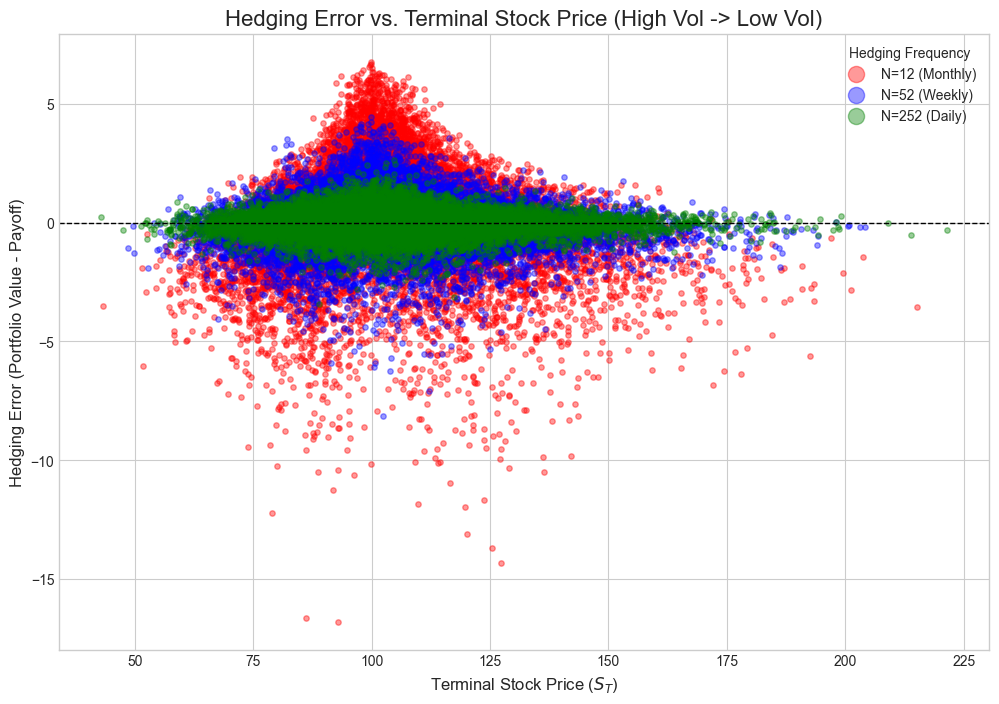

In [121]:
# --- Question 2.d Execution ---

# Parameters for the new time-varying volatility scenario
sigma_real1_hv = 0.28
sigma_real2_hv = 0.04
sigma_hedge1_hv = 0.28
sigma_hedge2_hv = 0.04
t_switch = 0.5

# Hedging frequencies to test
N_values_hv = [12, 52, 252]
results_hv = {}

# Run the simulation for each frequency
for n in N_values_hv:
    print(f"Running HV->LV simulation for N = {n}...")
    S_T, payoff, real_var, error = DeltaHedgeTV(
        S0, K, T, r, q, mu,
        sigma_real1_hv, sigma_real2_hv,
        sigma_hedge1_hv, sigma_hedge2_hv, t_switch,
        n, num_paths, opt_type
    )
    results_hv[n] = {'S_T': S_T, 'error': error}

# Create the scatterplot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

for n in N_values_hv:
    ax.scatter(results_hv[n]['S_T'], results_hv[n]['error'], 
               alpha=0.4, s=15, 
               c=colors[n], 
               label=labels[n])

ax.set_title('Hedging Error vs. Terminal Stock Price (High Vol -> Low Vol)', fontsize=16)
ax.set_xlabel('Terminal Stock Price ($S_T$)', fontsize=12)
ax.set_ylabel('Hedging Error (Portfolio Value - Payoff)', fontsize=12)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.legend(title='Hedging Frequency', markerscale=3)
plt.show()

In [122]:
# --- Consolidated Comparison Table ---

# Data from Constant Volatility (CV) case - Assuming 'results' from Q1 exists
table_data_cv = []
for n in N_values:
    errors = results[n]['error']
    table_data_cv.append({
        'Scenario': '1. Constant Vol (20%)',
        'Frequency': labels[n],
        'Mean Error': np.mean(errors),
        'Variance of Error': np.var(errors)
    })

# Data from Low-Vol -> High-Vol (LV-HV) case - Assuming 'results_tv' from 2.c exists
table_data_lv_hv = []
for n in N_values:
    errors = results_tv[n]['error']
    table_data_lv_hv.append({
        'Scenario': '2. Low-Vol First (4%->28%)',
        'Frequency': labels[n],
        'Mean Error': np.mean(errors),
        'Variance of Error': np.var(errors)
    })

# Data from High-Vol -> Low-Vol (HV-LV) case - Assuming 'results_hv' from 2.d exists
table_data_hv_lv = []
for n in N_values:
    errors = results_hv[n]['error']
    table_data_hv_lv.append({
        'Scenario': '3. High-Vol First (28%->4%)',
        'Frequency': labels[n],
        'Mean Error': np.mean(errors),
        'Variance of Error': np.var(errors)
    })

# Combine all data into a single DataFrame
df_cv = pd.DataFrame(table_data_cv)
df_lv_hv = pd.DataFrame(table_data_lv_hv)
df_hv_lv = pd.DataFrame(table_data_hv_lv)

combined_df = pd.concat([df_cv, df_lv_hv, df_hv_lv]).set_index(['Scenario', 'Frequency'])

print("--- Full Comparative Hedging Performance ---")
print(combined_df.to_string(float_format="%.4f"))


--- Full Comparative Hedging Performance ---
                                            Mean Error  Variance of Error
Scenario                    Frequency                                    
1. Constant Vol (20%)       N=12 (Monthly)     -0.0164             3.5067
                            N=52 (Weekly)      -0.0197             0.8587
                            N=252 (Daily)      -0.0048             0.1837
2. Low-Vol First (4%->28%)  N=12 (Monthly)     -0.0274             6.8210
                            N=52 (Weekly)       0.0108             1.7383
                            N=252 (Daily)      -0.0032             0.3653
3. High-Vol First (28%->4%) N=12 (Monthly)      0.0329             6.5988
                            N=52 (Weekly)       0.0093             1.5913
                            N=252 (Daily)      -0.0060             0.3295


# **3. This question is about determining the implied density of the terminal stock price from the volatility skew.**

### (a) Suppose that we have managed to fit the 1-year volatility smile of the equity option market using a function

$$\sigma(x) = ax^2 + bx + c$$

where $x$ is the "moneyness" ($x = K/S(0)$) and the initial stock price $S(0) = 100$ and $a = 0.025$, $b = -0.23$ and $c = 0.55$. Build a Python function that extracts the market-implied distribution of $S(T)$ at a 1-year horizon from $\sigma(x)$ using the Breeden-Litzenberger formula we derived in class. You can (should) use `FinancePy` to calculate the option prices.

In [123]:
S0 = 100.0
T = 1.0
r = 0.04
q = 0.0

a, b, c = 0.025, -0.23, 0.55
different_strike = np.arange(1, 250, step=1)

def volatility_smile(K, S0, a, b, c):
    m = K / S0
    return a * m**2 + b * m + c

# --- Compute implied vols and call prices for all strikes ---
vols = volatility_smile(different_strike, S0, a, b, c)
call_prices = [bs_value(S0, T, K, r, q, vol, OptionTypes.EUROPEAN_CALL.value)for K, vol in zip(different_strike, vols)]

# --- Use np.gradient twice to approximate second derivative wrt K ---
first_derivative = np.gradient(call_prices, different_strike)
second_derivative = np.gradient(first_derivative, different_strike)

# --- Breeden–Litzenberger implied risk-neutral density ---
g = np.exp(r * T) * second_derivative

# --- Normalize ---
integral = np.trapezoid(g, different_strike)
g /= integral

data_implied_probablity = pd.DataFrame({
    "K": different_strike,
    "g": g,
    "IV_Smile": vols
    })

In [124]:
different_strike = np.arange(1, 500, step=1)
r = 0.04
S0 = 100
q = 0.0
T = 1

vol_atm = data_implied_probablity[data_implied_probablity['K'] == 100]['IV_Smile'].values[0] * 100
pdf = (1/(vol_atm*np.sqrt(2*np.pi))) * np.exp(-0.5*((different_strike - 100)/vol_atm)**2)

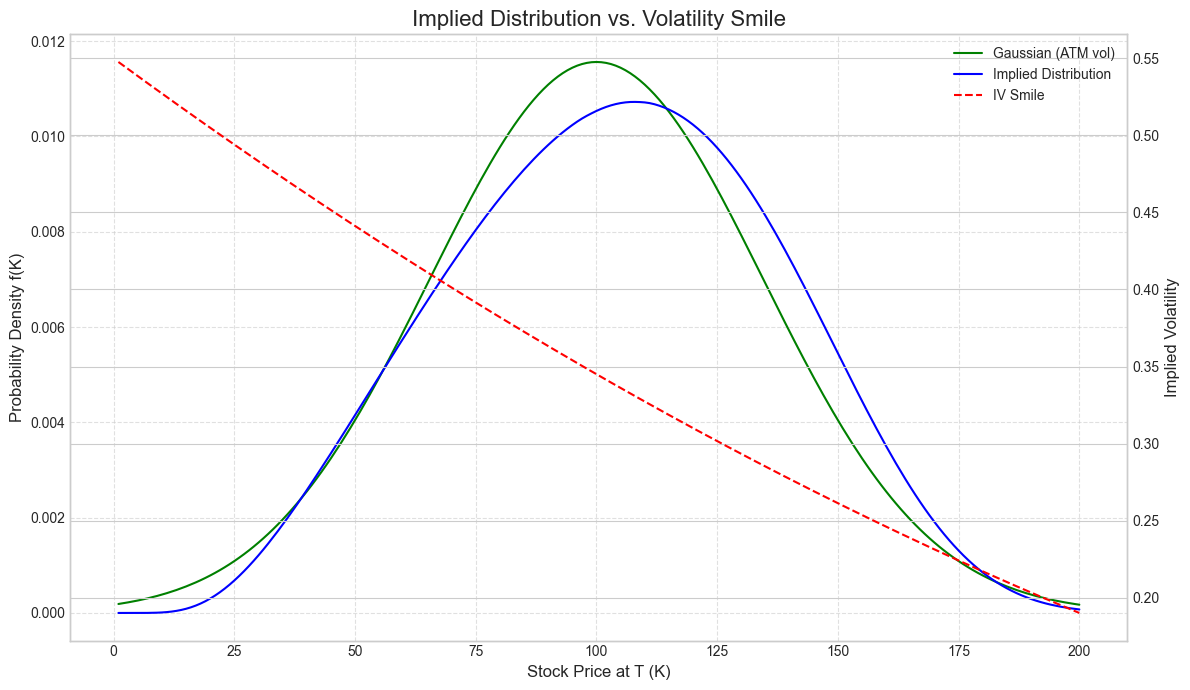

In [125]:
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_title('Implied Distribution vs. Volatility Smile', fontsize=16)
ax1.set_xlabel('Stock Price at T (K)', fontsize=12)
ax1.set_ylabel('Probability Density f(K)', fontsize=12)

# Plot the probability distribution
ax1.plot(different_strike[:200], pdf[:200], label="Gaussian (ATM vol)", c='g')
ax1.plot(data_implied_probablity['K'][:200], data_implied_probablity['g'][:200], color='blue', label='Implied Distribution')
ax1.grid(True, linestyle='--', alpha=0.6)

# --- Create and configure the secondary y-axis (ax2) for Volatility ---
ax2 = ax1.twinx()
ax2.set_ylabel('Implied Volatility', fontsize=12)
ax2.plot(data_implied_probablity['K'][:200], data_implied_probablity['IV_Smile'][:200], color='red', linestyle='--', label='IV Smile')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

fig.tight_layout()
plt.show()

### (b) A digital call option pays $1 if S(T ) > K and zero otherwise. Using the probability density function implied by this volatility smile, calculate a table of prices of the 1-year European digital call option with strikes at K = 60, 80, 100, 120, 140. Assume that r = 4% and q = 0.0%.

In [126]:
r = 0.04
T = 1.0
target_strikes = [60.0, 80., 100.0, 120.0, 140.0]
digit_payment = 1

digital_call_prices = []

for K_target in target_strikes:
    
    # 1. Isolate the part of the distribution where S(T) > K_target (We take >= because we assume that taking 74.99 is the same)
    tail_distribution = data_implied_probablity[data_implied_probablity['K'] >= K_target]
    
    # 2. Calculate the probability P(S(T) > K) by integrating the PDF
    prob_in_the_money = np.trapezoid(tail_distribution['g'], x=tail_distribution['K'])
    
    # 3. Calculate the digital call price using the formula
    discount_factor = np.exp(-r * T)
    price = discount_factor * prob_in_the_money * digit_payment 
    
    digital_call_prices.append(price)

results_table = pd.DataFrame({
    'Strike (K)': target_strikes,
    'Digital Call Price': digital_call_prices
    })

print("Table of Digital Call Option Prices:")
print(results_table.round(4))

Table of Digital Call Option Prices:
   Strike (K)  Digital Call Price
0        60.0              0.8551
1        80.0              0.7150
2       100.0              0.5276
3       120.0              0.3238
4       140.0              0.1504


### (c) Price the same set of digital call options using the Black-Scholes pricing formula for digital call options in the lecture notes or use FinancePy.

In [127]:
# --- Black-Scholes Digital Call Price Function ---
def black_scholes_digital_call(S_0, K, T, r, q, sigma):
    """
    Prices a European cash-or-nothing digital call option using the BS formula.
    """
    
    d2 = (np.log(S_0 / K) + (r - q - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    price = np.exp(-r * T) * norm.cdf(d2)

    return price

In [128]:
BS_Digital_Call_Price = []
difference_price = []

for i, K_target in enumerate(target_strikes):
    IV_smile_K_target = data_implied_probablity[data_implied_probablity['K'] == K_target]['IV_Smile'].values[0]
    BS_Digital_Call_Price.append( black_scholes_digital_call(S0, K_target, T, r, q, IV_smile_K_target) )
    difference_price.append( results_table.loc[i, 'Digital Call Price'] - BS_Digital_Call_Price[i] )

results_table['BS Digital Call Price'] = BS_Digital_Call_Price
results_table['Difference'] = difference_price

print("Table of Digital Call Option Prices:")
print(results_table.round(4))

Table of Digital Call Option Prices:
   Strike (K)  Digital Call Price  BS Digital Call Price  Difference
0        60.0              0.8551                 0.8300      0.0251
1        80.0              0.7150                 0.6636      0.0514
2       100.0              0.5276                 0.4587      0.0689
3       120.0              0.3238                 0.2590      0.0648
4       140.0              0.1504                 0.1089      0.0414


### (d) Explain why the results of (b) and (c) do not agree with each other and explain which prices you think are more correct.

### (e) Calculate the value of a put option with strike $100 which only pays out if the stock falls below $75 expiry (this is a European and not a path dependent option). Explain carefully and clearly how this was done.

In [129]:
r = 0.04
T = 1.0
target_strike = 100
knock_in_level = 75
digit_payment = 1

# 1. Isolate the part of the distribution where the option pays out (K < 75) 
payout_distribution = data_implied_probablity[data_implied_probablity['K'] <= knock_in_level]

# 2. Define the payoff function for this range
# The payoff is (100 - K) for each possible stock price K in the range.
payoff_values = np.maximum(target_strike - payout_distribution['K'], 0)

# 3. Calculate the expected payoff by integrating the payoff against the probability
# Expected Payoff = integral of [Payoff(K) * PDF(K)] dK
expected_payoff = np.trapezoid(payoff_values * payout_distribution['g'], x=payout_distribution['K'])

# 4. Discount the expected payoff to find the option's present value
discount_factor = np.exp(-r * T)
digital_put_price = discount_factor * expected_payoff


digital_put_price_put_plus_digital = 25 * data_implied_probablity[data_implied_probablity['K'] <= 75]['g'].sum() + bs_value(S0, T, 75, r, 0, data_implied_probablity[data_implied_probablity['K'] == 75]['IV_Smile'].values, OptionTypes.EUROPEAN_PUT.value)

print(f"The value of the put option with K=100 and payout only if S(T) < 75 is: {digital_put_price:.4f}")
print(f"The value of the put (Put + Digital) option with K=100 and payout only if S(T) < 75 is: {np.round(digital_put_price_put_plus_digital[0], 4)}")

The value of the put option with K=100 and payout only if S(T) < 75 is: 8.8395
The value of the put (Put + Digital) option with K=100 and payout only if S(T) < 75 is: 9.1477


# **4. This question is about Asian Options and the Control Variate Technique.**

### (a) Write a Python function which uses Monte-Carlo to price a 6-month Arithmetic Average Asian call option. Assume that the averaging starts in 3 months and then assume daily averaging period over the remaining 3 months of the option. Use 90 days in your simulation. Include the Python code in your pdf document.

In [130]:
def asian_options_mc(S0: float, 
                     K: float, 
                     r: float, 
                     q: float, 
                     sigma: float, 
                     T: float, 
                     T0: float, 
                     num_paths: int, 
                     num_steps: int) -> tuple[float, float, float, float, float]:
    """
    Prices Asian options (AA & GA) and calculates their variance and covariance.

    Args:
        S0 (float): Initial stock price.
        K (float): Strike price.
        r (float): Risk-free interest rate.
        q (float): Continuous dividend yield.
        sigma (float): Volatility of the stock.
        T (float): Time to expiry in years.
        T0 (float): Time to the start of the averaging period in years.
        num_paths (int): Number of Monte Carlo simulation paths.
        num_steps (int): Number of steps in the averaging period.

    Returns:
        tuple[float, float, float, float, float]: A tuple containing:
            - Price of the Arithmetic Average (AA) option
            - Price of the Geometric Average (GA) option
            - Variance of the AA discounted payoffs
            - Variance of the GA discounted payoffs
            - Covariance between the AA and GA discounted payoffs
    """
    
    Z1 = np.random.standard_normal((num_paths))
    Z2 = np.random.standard_normal((num_paths, num_steps))

    avg_period = T - T0
    dt = avg_period / num_steps
    drift = r - q - 0.5 * sigma**2

    log_return_to_T0 = drift * T0 + sigma * np.sqrt(T0) * Z1
    log_increments = drift * dt + sigma * np.sqrt(dt) * Z2

    S_at_T0 = S0 * np.exp( log_return_to_T0 )
    S_asian_paths = S_at_T0[:, np.newaxis] * np.exp( np.cumsum( log_increments, axis=1 ) )
    
    S_asian_AA = np.sum( S_asian_paths, axis=1 ) / num_steps
    payoff_asian_AA = np.maximum( S_asian_AA - K, 0 )
    discounted_payoff_AA = payoff_asian_AA * np.exp(-r * T)
    price_asian_AA = np.mean( discounted_payoff_AA ) 

    S_asian_GA = np.exp( np.sum( np.log(S_asian_paths), axis=1) / num_steps )
    payoff_asian_GA = np.maximum( S_asian_GA - K, 0 )
    discounted_payoff_GA = payoff_asian_GA * np.exp(-r * T)
    price_asian_GA = np.mean( discounted_payoff_GA )

    variance_AA = np.var( discounted_payoff_AA, ddof=1 )
    variance_GA = np.var( discounted_payoff_GA, ddof=1 )

    covariance_AA_GA = np.cov( discounted_payoff_AA, discounted_payoff_GA )[0, 1]

    return price_asian_AA, price_asian_GA, variance_AA, variance_GA, covariance_AA_GA

### (b) Using this function, value an Arithmetic Average option with a current stock price of $100, a strike price of $100, risk free rate of 4% where the stock price volatility is 25%. Use P=10,000 paths.
### (c) Extend the Arithmetic Average function to also value a Geometric Average option using the same stock price path as the Arithmetic Average option. Make sure you use the same random numbers to calculate both at the same time. The function should now output the prices of both the Arithmetic and Geometric Average options.
### (d) Extend this function to calculate the variance of the arithmetic average option price and Geometric average option price and the covariance of the values of the discounted option payoffs across all of the P paths. Your function should return a vector of 5 numbers, the geometric and arithmetic option prices as well as their respective variances and covariance. Provide a code listing in your answer.

In [131]:
# --- Demonstration using parameters from 4(b) ---
S0 = 100.0
K = 100.0
r = 0.04
q = 0.0
sigma = 0.25
T0 = 0.25
T = 0.5
num_paths = 10_000
num_steps = 90

# Call the new analysis function
p_aa, p_ga, v_aa, v_ga, cov = asian_options_mc(S0, K, r, q, sigma, T, T0, num_paths, num_steps)

print(f"RESULTS FROM MONTE CARLO ANALYSIS:")
print(f"-----------------------------------")
print(f"Arithmetic Average Option Price : {np.round(p_aa, 4)}")
print(f"Geometric Average Option Price  : {np.round(p_ga, 4)}")
print(f"Variance of AA Option Price     : {np.round(v_aa, 4)}")
print(f"Variance of GA Option Price     : {np.round(v_ga, 4)}")
print(f"Covariance (AA vs GA)           : {np.round(cov, 4)}")

RESULTS FROM MONTE CARLO ANALYSIS:
-----------------------------------
Arithmetic Average Option Price : 6.5783
Geometric Average Option Price  : 6.5038
Variance of AA Option Price     : 94.9803
Variance of GA Option Price     : 93.6445
Covariance (AA vs GA)           : 94.3049


### (e) Calculate the price of the Arithmetic and Geometric options with a stock price of S = $100, r = 5% and q = 1% where the σ = 30% and K = 100. Use P = 5,000 paths.

In [132]:
# Parameters for question 4(e)
S0 = 100.0
K = 100.0
r = 0.05       # New risk-free rate
q = 0.01       # New dividend yield
sigma = 0.30   # New volatility
T0 = 0.25
T = 0.5
num_paths = 5_000 # New number of paths
num_steps = 90

# We can use the same analysis function from part (d)
p_aa, p_ga, v_aa, v_ga, cov = asian_options_mc(S0, K, r, q, sigma, T, T0, num_paths, num_steps)

print(f"RESULTS FROM MONTE CARLO ANALYSIS:")
print(f"-----------------------------------")
print(f"Arithmetic Average Option Price : {np.round(p_aa, 4)}")
print(f"Geometric Average Option Price  : {np.round(p_ga, 4)}")
print(f"Variance of AA Option Price     : {np.round(v_aa, 4)}")
print(f"Variance of GA Option Price     : {np.round(v_ga, 4)}")
print(f"Covariance (AA vs GA)           : {np.round(cov, 4)}")

RESULTS FROM MONTE CARLO ANALYSIS:
-----------------------------------
Arithmetic Average Option Price : 7.7692
Geometric Average Option Price  : 7.662
Variance of AA Option Price     : 138.7316
Variance of GA Option Price     : 136.3951
Covariance (AA vs GA)           : 137.5479


### (f) Assuming we now have T0 = 0, value the geometric option. And using this as a control and the other outputs calculate the best estimate of the value of the arithmetic average option.

In [133]:
def asian_GA_options_analytical(S0, K, r, q, sigma, T, T0):
    """
    Calculates the analytical price of a forward-starting
    Geometric Average Asian call option using the Kemna-Vorst formula.
    """
    # 1. Calculate the intermediate moments M and V (Your code for this was correct)
    M = (r - q - sigma**2 / 2) * (T0 + 0.5 * (T - T0))
    V = sigma**2 * (T0 + (T - T0) / 3)
    sqrt_V = np.sqrt(V)

    d1 = (np.log(S0 / K) + M + V) / sqrt_V
    d2 = d1 - sqrt_V

    asian_call_price = np.exp(-r * T) * (S0 * np.exp(M + 0.5 * V) * norm.cdf(d1) - K * norm.cdf(d2))

    return asian_call_price


In [134]:
S0 = 100
K = 100
r = 0.05
q = 0.01
sigma = 0.30
T = 0.50
T0 = 0.0
num_paths = 5_000       
num_steps = 180

# Monte Carlo estimates: AA mean, GA mean, and their sample variances/covariance
p_aa, p_ga, v_aa, v_ga, cov = asian_options_mc(S0, K, r, q, sigma, T, T0, num_paths, num_steps)

# Analytic GA price (acts as known-mean control)
price_analytical_ga = asian_GA_options_analytical(S0, K, r, q, sigma, T, T0)

# Optimal CV slope
b = cov / v_ga

# A_cv = A_bar + b * (G* - G_bar)
price_improved_aa = p_aa + b * (price_analytical_ga - p_ga)

# --- Formatted Output ---
print(f"| Metric                            | Method/Notes     | Value  |")
print(f"|:----------------------------------|:-----------------|:-------|")
print(f"| GA Option Price                   | Analytical       | {price_analytical_ga:.4f} |")
print(f"| GA Option Price                   | Monte Carlo      | {p_ga:.4f} |")
print(f"| AA Option Price                   | Monte Carlo      | {p_aa:.4f} |")
print(f"| Optimal 'b' Coefficient           | Cov/Var          | {b:.4f} |")
print(f"| Improved AA Option Price          | Control Variate  | {price_improved_aa:.4f} |")


| Metric                            | Method/Notes     | Value  |
|:----------------------------------|:-----------------|:-------|
| GA Option Price                   | Analytical       | 5.0893 |
| GA Option Price                   | Monte Carlo      | 5.1619 |
| AA Option Price                   | Monte Carlo      | 5.3750 |
| Optimal 'b' Coefficient           | Cov/Var          | 1.0363 |
| Improved AA Option Price          | Control Variate  | 5.2998 |


# **5. This question is about Swap and Swaption Pricing.**

### (a) You rotate on the swap desk for a day. Using FinancePy create an IBOR curve using swap rates with maturities of 2-10 years and the IBOR rates given in Table 1. Use a semi-annual fixed frequency and a daycount type of THIRTY_E_360_ISDA. Demonstrate that all swaps price to zero.

In [135]:
valuation_date = Date(3, 10, 2025)

fixedDCCType = DayCountTypes.THIRTY_E_360_ISDA
fixedFreqTyp = FrequencyTypes.SEMI_ANNUAL
swapType = SwapTypes.PAY
swaps: list[IborSwap] = []

depoDCCType = DayCountTypes.THIRTY_E_360_ISDA
depos: list[IborDeposit] = []

rate_dict = {"1M": 0.011,
             "2M": 0.0115,
             "3M": 0.0123,
             "6M": 0.0132, 
             "12M": 0.0140, 
             "2Y": 0.0151, 
             "3Y": 0.0153, 
             "4Y": 0.0155, 
             "5Y": 0.0159, 
             "6Y": 0.0161, 
             "7Y": 0.0165, 
             "8Y": 0.0169, 
             "9Y": 0.0171, 
             "10Y": 0.0173}

deposit_maturity = ["1M", "2M", "3M", "6M", "12M"]

for maturity in rate_dict.keys():
    if maturity in deposit_maturity:
        deposit_rate = rate_dict[maturity]
        depo = IborDeposit(valuation_date, valuation_date.add_months(int(maturity[:-1])), deposit_rate, depoDCCType)
        depos.append(depo)
    else:
        swap_rate = rate_dict[maturity]
        swap = IborSwap(valuation_date, valuation_date.add_years(int(maturity[:-1])), swapType, swap_rate, fixedFreqTyp, fixedDCCType)
        swaps.append(swap)

libor_curve = IborSingleCurve(valuation_date, depos, [], swaps)

In [136]:
for depo in depos:
    v = depo.value(valuation_date, libor_curve)
    print("Depo Value: %10.6f"% v)

print()

for swap in swaps:
    v = swap.value(valuation_date, libor_curve)
    print("Swap Value: %12.8f" % v)

Depo Value: 100.000000
Depo Value: 100.000000
Depo Value: 100.000000
Depo Value: 100.000000
Depo Value: 100.000000

Swap Value:  -0.00000376
Swap Value:  -0.00001488
Swap Value:  -0.00002206
Swap Value:  -0.00002855
Swap Value:  -0.00002640
Swap Value:  -0.00007506
Swap Value:  -0.00000000
Swap Value:  -0.00008453
Swap Value:  -0.00008951


In [137]:
years = np.linspace(0.01, 10, 500)
dates = valuation_date.add_years(years)
zero_rates = libor_curve.zero_rate(dates)
fwd_rates = libor_curve.fwd(dates)
par_rates = libor_curve.swap_rate(valuation_date, dates)

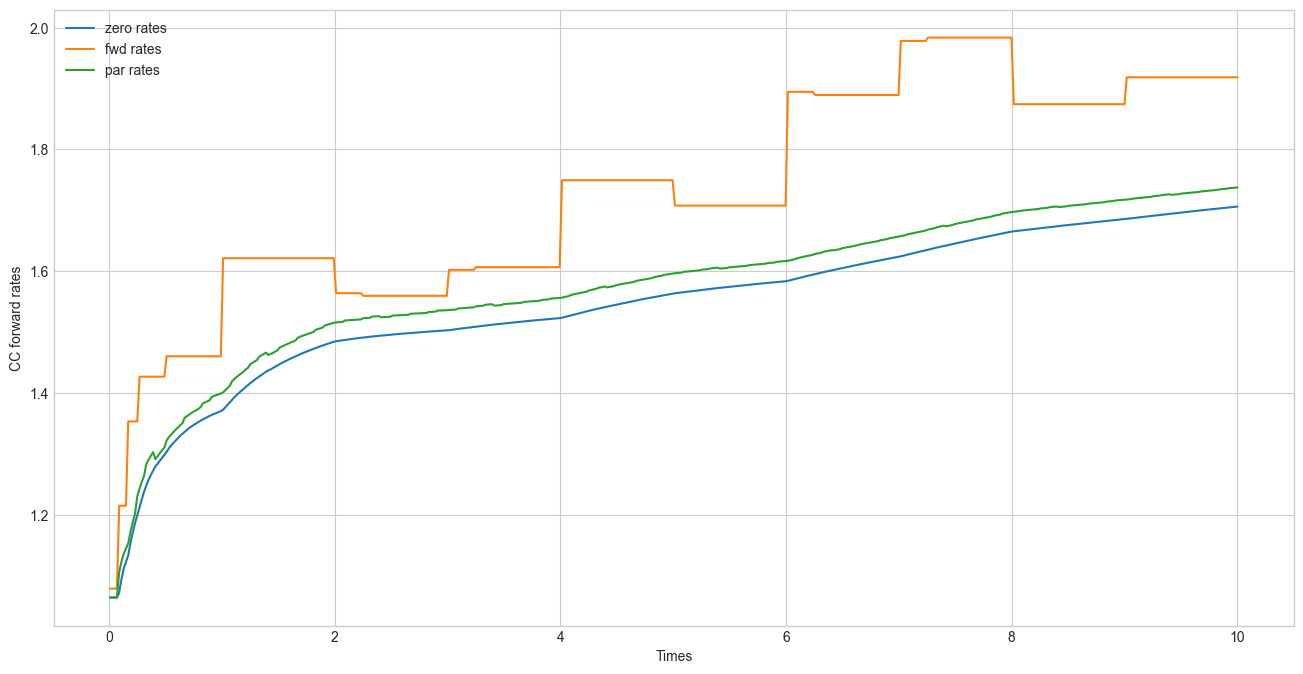

In [138]:
plt.figure(figsize=(16,8))
plt.plot(years, zero_rates*100, label="zero rates")
plt.plot(years, fwd_rates*100, label = "fwd rates")
plt.plot(years, par_rates*100, label = "par rates")
plt.xlabel("Times")
plt.ylabel("CC forward rates")
plt.legend()
plt.show()

### (b) You are asked to manage a (small) book of swaps given in Table 2. First, mark-to market these swaps (i.e. determine the value of each swap and the whole portfolio).

In [139]:
swaps_book = [
    {"Effective date": Date(3, 4, 2022), "Maturity": "10Y", "Freq": FrequencyTypes.SEMI_ANNUAL, "Rate": 0.0140, "side": SwapTypes.RECEIVE},
    {"Effective date": Date(3, 10, 2023), "Maturity": "4Y", "Freq": FrequencyTypes.ANNUAL, "Rate": 0.0152, "side": SwapTypes.PAY},
    {"Effective date": Date(3, 10, 2021), "Maturity": "12Y", "Freq": FrequencyTypes.ANNUAL, "Rate": 0.02, "side": SwapTypes.RECEIVE},
    {"Effective date": Date(3, 4, 2024), "Maturity": "5Y", "Freq": FrequencyTypes.SEMI_ANNUAL, "Rate": 0.021, "side": SwapTypes.PAY}
    ]

swaps_pv: list[float] = []
portfolio_pv = 0.0

for swap in swaps_book:
    value_swap = IborSwap(swap['Effective date'], 
                          swap['Effective date'].add_years(int(swap['Maturity'][:-1])),
                          swap['side'],
                          swap['Rate'],
                          swap['Freq'],
                          fixed_dc_type = DayCountTypes.THIRTY_E_360_ISDA,
                          float_freq_type = FrequencyTypes.SEMI_ANNUAL,
                          float_dc_type = DayCountTypes.THIRTY_E_360_ISDA)
    
    pv = value_swap.value(valuation_date, libor_curve)
    swaps_pv.append(pv)
    portfolio_pv += pv

    print(f"{swap['side'].name:7s} | {swap['Maturity']:>3s} | rate = {swap['Rate']*100:5.3f}% | PV = {pv:,.2f}")

print(f"\nPortfolio MTM = {portfolio_pv:,.2f}")

RECEIVE | 10Y | rate = 1.400% | PV = -14,280.08
PAY     |  4Y | rate = 1.520% | PV = -81.15
RECEIVE | 12Y | rate = 2.000% | PV = 22,554.21
PAY     |  5Y | rate = 2.100% | PV = -19,001.07

Portfolio MTM = -10,808.08


### (c) Now that you know the value, you are interested in the risk of the book. Calculate the change in value of the portfolio for with respect to a 1bp change in the 2Y-10Y swap rates. Explain how you would hedge this portfolio. Do not do any further calculations.

In [140]:
swaps_choc: list[IborSwap] = []
swaps_pv_choc: list[float] = []
portfolio_pv_choc = 0.0
choc_bp = 0.0001

for maturity in rate_dict.keys():
    if maturity in deposit_maturity:
        continue
    else:
        swap_rate_choc = rate_dict[maturity] + choc_bp
        swap_choc = IborSwap(valuation_date, valuation_date.add_years(int(maturity[:-1])), swapType, swap_rate_choc, fixedFreqTyp, fixedDCCType)
        swaps_choc.append(swap_choc)

libor_curve_choc = IborSingleCurve(valuation_date, depos, [], swaps_choc)

for swap in swaps_book:
    value_swap = IborSwap(swap['Effective date'], 
                          swap['Effective date'].add_years(int(swap['Maturity'][:-1])),
                          swap['side'],
                          swap['Rate'],
                          swap['Freq'],
                          fixed_dc_type = DayCountTypes.THIRTY_E_360_ISDA,
                          float_freq_type = FrequencyTypes.SEMI_ANNUAL,
                          float_dc_type = DayCountTypes.THIRTY_E_360_ISDA)
    
    pv_choc = value_swap.value(valuation_date, libor_curve_choc)
    swaps_pv_choc.append(pv_choc)
    portfolio_pv_choc += pv_choc

    print(f"{swap['side'].name:7s} | {swap['Maturity']:>3s} | rate = {swap['Rate']*100:5.3f}% | PV = {pv_choc:,.2f}")

difference_pv = np.array(swaps_pv_choc) - np.array(swaps_pv)
total_difference_pv = np.sum(difference_pv)

print(f"\nPortfolio MTM = {portfolio_pv_choc:,.2f}")
print()

for index, diff in enumerate(difference_pv):
    print(f"{swaps_book[index]['side'].name:7s} | {swaps_book[index]['Maturity']:>3s} "
          f"| rate = {swaps_book[index]['Rate']*100:5.3f}% | Difference PV = {diff:,.2f}")

print()
print(f"Total Difference PV = {total_difference_pv:,.2f}")

RECEIVE | 10Y | rate = 1.400% | PV = -14,891.39
PAY     |  4Y | rate = 1.520% | PV = 116.27
RECEIVE | 12Y | rate = 2.000% | PV = 21,793.73
PAY     |  5Y | rate = 2.100% | PV = -18,658.38

Portfolio MTM = -11,639.77

RECEIVE | 10Y | rate = 1.400% | Difference PV = -611.31
PAY     |  4Y | rate = 1.520% | Difference PV = 197.41
RECEIVE | 12Y | rate = 2.000% | Difference PV = -760.48
PAY     |  5Y | rate = 2.100% | Difference PV = 342.69

Total Difference PV = -831.68


### (d) Now you are moving to the swaption desk for a day. Calculate the forward rate for a 4×6 year swap with semi-annual fixed leg payments. Show the value for Z(t, T1), Z(t, T2) and the swap PV01.

In [141]:
T1: Date = valuation_date.add_years(4)   # swap start in 4y
T2: Date = valuation_date.add_years(6)   # swap ends in 6y

# Discount factors Z(t,T)
Z1 = libor_curve.df(T1)
Z2 = libor_curve.df(T2)

# Semi-annual fixed leg payment dates: T1+6m, T1+12m, T1+18m, T2
pay_dates = [T1.add_months(6), T1.add_months(12), T1.add_months(18), T2]

# PV01 (swap annuity) with 30/360 semi-annual => accrual ≈ 0.5 each
dfs = [libor_curve.df(d) for d in pay_dates]
PV01 = sum(0.5 * libor_curve.df(d) for d in pay_dates)

# Forward par swap rate F = (Z1 - Z2) / PV01
F = (Z1 - Z2) / PV01

print(f"Z(t, T1=4Y) = {Z1:.10f}")
print(f"Z(t, T2=6Y) = {Z2:.10f}")
print(f"Swap PV01   = {PV01:.10f}")
print(f"Forward 4 x 6y par rate (semi-annual fixed) = {F*100:.6f} %")

Z(t, T1=4Y) = 0.9400612415
Z(t, T2=6Y) = 0.9081193696
Swap PV01   = 1.8398547741
Forward 4 x 6y par rate (semi-annual fixed) = 1.736108 %


### (e) Now using Black’s model, value a 4 × 6 Payer and a 4 × 6 Receiver swaption with a strike 1.75%. Assume a swaption volatility of 25%. Explain the prices.

In [142]:
K = 0.0175
sigma = 0.25
tau = (T1 - valuation_date) / 360.0 

black = Black(volatility=sigma)
payer_val = PV01 * black.value(F, K, tau, df=1.0, opt_type=OptionTypes.EUROPEAN_CALL)
receiver_val = PV01 * black.value(F, K, tau, df=1.0, opt_type=OptionTypes.EUROPEAN_PUT)

print(f"Payer swaption    = {payer_val:.8f} per 1 notional")
print(f"Receiver swaption = {receiver_val:.8f} per 1 notional")
print(f"Parity check      = {payer_val - receiver_val - PV01*(F-K):.3e}")

Payer swaption    = 0.00624898 per 1 notional
Receiver swaption = 0.00650456 per 1 notional
Parity check      = -1.626e-19


### (f) Now that you know the value of the swaptions you are again focussed on the risk. Calculate the change in value for the payer and receiver swaption with respect to a 1bp change in the 2Y-10Y swap rates. Explain how these swaptions would be hedged? Show the results in a table. Do not do any further calculations.

In [143]:
# --- Compute bumped values for 1bp parallel shift ---
Z1_choc = libor_curve_choc.df(T1)
Z2_choc = libor_curve_choc.df(T2)

PV01_choc = sum(0.5 * libor_curve_choc.df(d) for d in pay_dates)
F_choc = (Z1_choc - Z2_choc) / PV01_choc

payer_choc = PV01_choc * black.value(F_choc, K, tau, df=1.0, opt_type=OptionTypes.EUROPEAN_CALL)
receiver_choc = PV01_choc * black.value(F_choc, K, tau, df=1.0, opt_type=OptionTypes.EUROPEAN_PUT)

# --- Calculate the changes in value ---
payer_change = payer_choc - payer_val
receiver_change = receiver_choc - receiver_val

# --- Pretty print results ---
print("=== 5(f) Swaption ΔPV for +1bp in 2Y–10Y rates ===")
print(f"Z(t,T1=4Y): {Z1:.8f}  →  {Z1_choc:.8f}")
print(f"Z(t,T2=6Y): {Z2:.8f}  →  {Z2_choc:.8f}")
print(f"PV01:       {PV01:.8f}  →  {PV01_choc:.8f}")
print(f"Fwd Rate:   {F*100:.5f}% → {F_choc*100:.5f}%\n")

print(f"Payer Swaption ΔPV:    {payer_change:,.8f} per 1 notional")
print(f"Receiver Swaption ΔPV: {receiver_change:,.8f} per 1 notional")

=== 5(f) Swaption ΔPV for +1bp in 2Y–10Y rates ===
Z(t,T1=4Y): 0.94006124  →  0.93968641
Z(t,T2=6Y): 0.90811937  →  0.90757659
PV01:       1.83985477  →  1.83889343
Fwd Rate:   1.73611% → 1.74615%

Payer Swaption ΔPV:    0.00010669 per 1 notional
Receiver Swaption ΔPV: -0.00007809 per 1 notional


# **6. This question is about CDS Valuation and Risk.**

### (a) Today you move to the CDS desk. The first thing they ask you to do is build the curve based on the quotes for today for Company DoOrDie. Use FinancePy’s CDS functions (CDS and CDSCurve) to build a cds curve for this company. Use a recovery rate of 40%.

In [144]:
cds_dict = {"1Y": 70,
            "2Y": 74,
            "3Y": 80,
            "4Y": 85,
            "5Y": 88}

recovery_rate = 0.4

cds_list: list[CDS] = [CDS(valuation_date, valuation_date.add_years(int(maturity[:-1])), bps / 10_000) for maturity, bps in cds_dict.items()]
cds_curve = CDSCurve(valuation_date, cds_list, libor_curve, recovery_rate) 

for cds in cds_list:
    cds_value = cds.value(valuation_date, cds_curve, recovery_rate)
    print(f"Clean PV: ${cds_value['clean_pv']:,.8f}  Dirty PV: ${cds_value['dirty_pv']:,.8f}")

Clean PV: $0.00731081  Dirty PV: $0.00731081
Clean PV: $0.00582327  Dirty PV: $0.00582327
Clean PV: $-0.00001321  Dirty PV: $-0.00001321
Clean PV: $-0.00001779  Dirty PV: $-0.00001779
Clean PV: $-0.00001945  Dirty PV: $-0.00001945


In [145]:
cds_curve

XXXXX
[1.         0.98842383 0.97549879 0.96037126 0.94416897 0.92823115]


OBJECT TYPE: CDSCurve
TIME,SURVIVAL_PROBABILITY
 0.0000000,  1.0000000
 1.0000000,  0.9884238
 2.0000000,  0.9754988
 3.0027397,  0.9603713
 4.0027397,  0.9441690
 5.0027397,  0.9282312

### (b) Determine the market spread of a 3.5-year CDS that matures on the 20 March 2029. Explain how the value is determined.

In [146]:
maturity_cds = Date(20, 3, 2029)
spd = CDS(valuation_date, maturity_cds, 0.0).par_spread(valuation_date, cds_curve, recovery_rate)
print(np.round(spd * 10_000, 2), 'bps')

82.46 bps


### (c) Calculate the value of an existing long protection CDS contract traded with a contractual spread of 120bp with a maturity of 21 March 2029 and a notional of $20m.

In [147]:
maturity = Date(21, 3, 2029)
notional = 20_000_000
coupon = 120 / 10_000

pos = CDS(valuation_date, maturity, coupon, notional=notional, long_protect=True)
pv = pos.value(valuation_date, cds_curve, recovery_rate)

print(f"Clean PV: ${pv['clean_pv']:,.2f}  Dirty PV: ${pv['dirty_pv']:,.2f}")

Clean PV: $-252,512.23  Dirty PV: $-259,845.56


### (d) Recalculate the value of the contract for R = 0%, 10%, 20%, 30%. Are the changes significant or not? Can you explain why?

In [148]:
for R in [0.0, 0.10, 0.20, 0.30, 0.40]:
    pv = pos.value(valuation_date, cds_curve, R)
    print(f"R={int(R*100):2d}%  Clean PV = ${pv['clean_pv']:,.2f}  Dirty PV = ${pv['dirty_pv']:,.2f}")

R= 0%  Clean PV = $114,530.37  Dirty PV = $107,197.04
R=10%  Clean PV = $22,769.72  Dirty PV = $15,436.39
R=20%  Clean PV = $-68,990.93  Dirty PV = $-76,324.26
R=30%  Clean PV = $-160,751.58  Dirty PV = $-168,084.91
R=40%  Clean PV = $-252,512.23  Dirty PV = $-259,845.56


### (e) Calculate the change in the CDS value to a 1bp increase in each of the 1Y, 2Y, 3Y, 4Y and 5Y CDS market rates. Show the results in a table. Explain what you find and how a dealer would hedge this 3.5 year CDS trade. Do not do any further calculations.

In [149]:
cds_face_value = CDS(valuation_date, valuation_date.add_years(3.5), coupon).value(valuation_date, cds_curve, recovery_rate)
choc_to_cds: list[CDS] = [CDS(valuation_date, valuation_date.add_years(int(maturity[:-1])), (bps + 1) / 10_000) for maturity, bps in cds_dict.items()]

for index in range(len(choc_to_cds)):
    cds_with_c = cds_list.copy()
    cds_with_c[index] = choc_to_cds[index]

    cds_curve_c = CDSCurve(valuation_date, cds_with_c, libor_curve, recovery_rate)
    cds_value_c = CDS(valuation_date, valuation_date.add_years(3.5), coupon).value(valuation_date, cds_curve_c, recovery_rate)
    print(f"The following change when we bump {list(cds_dict.keys())[index]}: {cds_value_c['clean_pv'] - cds_face_value['clean_pv']}")

The following change when we bump 1Y: 0.5796885927775293
The following change when we bump 2Y: 1.187048942396359
The following change when we bump 3Y: 145.80274844682208
The following change when we bump 4Y: 192.29057423498307
The following change when we bump 5Y: 0.0
